# 1. Graphviz를 사용해 트리 plot

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# 모델 생성
dt_clf = DecisionTreeClassifier(random_state=156, max_depth=3)

# 데이터 로드, train/test 셋 분리
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=11)

# 모델 학습
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=156)

In [12]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot파일을 생성함.
# 위에서 학습된 트리모델을 tree.dot파일로 실제 저장함(같은파일위치에).
export_graphviz(dt_clf, out_file="tree.dot", class_names = iris_data.target_names, \
    feature_names = iris_data.feature_names, impurity=True, filled=True)

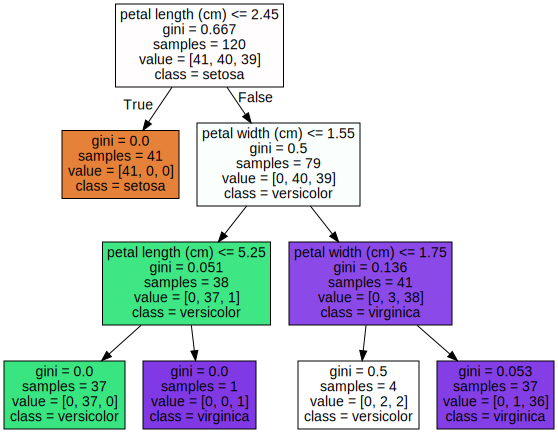

In [13]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz로 읽어서 여기(주피터)에다 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

# 2. 지니계수(불순수도) 계산
- 순수도 = 엔트로피 = 1 - 지니계수

A1 = {빨, 빨, 빨, 빨}
A2 = {빨, 빨, 파, 파}
A3 = {빨, 파, 파, 파}

지니계수 = 1 - 시그마(확률i^2)

A1 = 1 - (4/4^2 + 0/4^2) = 1 - 1 = 0    : 0은 순수하다는 말
A2 = 1 - (1/2^2 + 1/2^2) = 1 - 1/2 = 0.5
A3 = 1 - (1/4^2 + 3/4^2) = 1 - 5/8 = 3/8 = 0.375

# 3. 오버피팅 확인 & 방지(파라미터 설정)

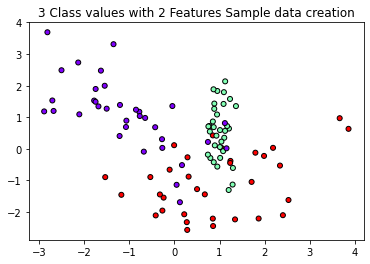

In [14]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("3 Class values with 2 Features Sample data creation")

# 샘플데이터 생성
## 2차원 시각화를 위해 feature는 2개, 클래스는 3개의 분류샘플데이터 생성
X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                            n_classes=3, n_clusters_per_class=1, random_state=0)

# 2개의 feature로 2차원 시각화, 각 클래스 값은 다른색깔로 표시.
plt.scatter(X_features[:,0], X_features[:,1], marker="o", c=y_labels, s=25, cmap="rainbow", edgecolors="k")

In [17]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig, ax = plt.subplots()
    
    # 학습 데이터 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap="rainbow", edgecolors="k",
                clim=(y.min(), y.max()), zorder=3)
    ax.axis("tight")
    ax.axis("off")
    xlim_start, xlim_end = ax.get_xlim()
    ylim_start, ylim_end = ax.get_ylim()
    
    # 모델 학습
    model.fit(X,y)
    
    # meshgrid형태인 모든 좌표값으로 예측 수행
    xx, yy = np.meshgrid(np.linspace(xlim_start, xlim_end, num=200), np.linspace(ylim_start, ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf()를 이용하여 class boundary를 visualization 수행
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                            levels=np.arange(n_classes+1) - 0.5,
                            cmap="rainbow", clim=(y.min(), y.max()),
                            zorder=1)
    

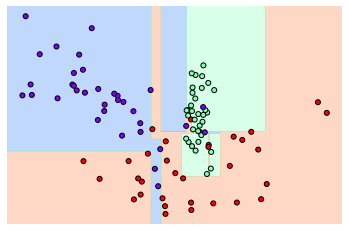

In [18]:
from sklearn.tree import DecisionTreeClassifier

# 특정한 트리 생성 제약없는 결정 트리의 Decision Boundary 시각화
dt_clf = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

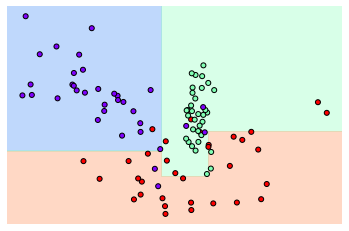

In [19]:
# leaf수를 6으로 제약하여 시각화. 과적합 방지.
dt_clf = DecisionTreeClassifier(min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

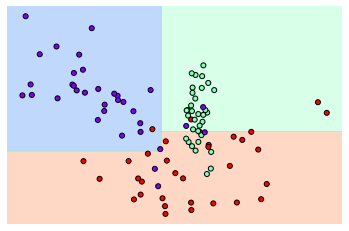

In [22]:
# leaf수를 6으로 제약하여 시각화. 과적합 방지.
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

# 4. 앙상블 학습
## - 보팅(Voting), 배깅(Bagging), 부스팅(Boosting)
- 보팅과 배깅은 여러개의 분류기(분류모델)를 사용해 얻은 여러 결과값을 바탕으로 최종 예측을 하는 방식이다.
- 둘의 차이점은 각 분류기가 학습하는 데이터 샘플링이 다른것.
  - 배깅의 샘플링 방식은 하나의 학습데이터에서 일부가 중첩되게 샘플링하여 서브세트 생성 -> 이것이 Bootstrap방식. Bagging의 B가 Bootstrap임.
  - 배깅의 대표적인 알고리즘이 랜덤포레스트

## 4.1 Voting

In [23]:
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [39]:
# 개별 모델은 로지스틱 회귀와 KNN임
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))
print("--------------------------------------")

# 개별 모델의 학습/예측/평가
classifiers = [vo_clf, lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))
    #print(f'{class_name} 정확도 : {accuracy_score(y_test, pred)}')

Voting 분류기 정확도 : 0.9474
--------------------------------------
VotingClassifier 정확도 : 0.9474
LogisticRegression 정확도 : 0.9386
KNeighborsClassifier 정확도 : 0.9386


In [38]:
# 위 voting에 분류기 추가!
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier(random_state=0)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf), ('DC', dt_clf), ("RF", rf_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))
print("--------------------------------------")

# 개별 모델의 학습/예측/평가
classifiers = [vo_clf, dt_clf, lr_clf, knn_clf, rf_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))
    #print(f'{class_name} 정확도 : {accuracy_score(y_test, pred)}')

Voting 분류기 정확도 : 0.9474
--------------------------------------
VotingClassifier 정확도 : 0.9474
DecisionTreeClassifier 정확도 : 0.9474
LogisticRegression 정확도 : 0.9386
KNeighborsClassifier 정확도 : 0.9386
RandomForestClassifier 정확도 : 0.9561
